In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from rdkit import Chem
from rdkit.Chem import PandasTools
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('small_molecules_smiles_only_05222024_sm.csv')

In [4]:
df.head()

,good,canon_smiles
0,0,CC1(C)CCC(c2ccc(Cl)cc2)=C(CN2CCN(c3ccc(C(=O)NS...
1,0,CN(C)CC[C@H](CSc1ccccc1)Nc1ccc(S(=O)(=O)NC(=O)...
2,0,Cc1ccc(F)c(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)c...
3,0,C[C@@]1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
4,0,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1


In [5]:
PandasTools.AddMoleculeColumnToFrame(df, 'canon_smiles', 'Molecule')
df.head()

[20:36:41] WARNING: not removing hydrogen atom without neighbors
[20:36:41] WARNING: not removing hydrogen atom without neighbors
Failed to patch pandas - unable to change molecule rendering


,good,canon_smiles,Molecule
0,0,CC1(C)CCC(c2ccc(Cl)cc2)=C(CN2CCN(c3ccc(C(=O)NS...,<rdkit.Chem.rdchem.Mol object at 0x00000231828...
1,0,CN(C)CC[C@H](CSc1ccccc1)Nc1ccc(S(=O)(=O)NC(=O)...,<rdkit.Chem.rdchem.Mol object at 0x00000231828...
2,0,Cc1ccc(F)c(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)c...,<rdkit.Chem.rdchem.Mol object at 0x00000231828...
3,0,C[C@@]1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,<rdkit.Chem.rdchem.Mol object at 0x00000231828...
4,0,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,<rdkit.Chem.rdchem.Mol object at 0x00000231828...


In [6]:
df['Molecule'].values

array([<rdkit.Chem.rdchem.Mol object at 0x00000231828B29D0>,
       <rdkit.Chem.rdchem.Mol object at 0x00000231828B2490>, ...,
       <rdkit.Chem.rdchem.Mol object at 0x00000231848ABC30>], dtype=object)

In [7]:
from molvecgen.vectorizers import SmilesVectorizer

smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(df.Molecule.values)

In [8]:
print(smivec.charset)
smivec.dims

a7\IFC+HnRl.Zc-Os(@Kt5N4o)er13[B/6]=Pu#S2M^$?


(275, 45)

In [9]:
X = df.Molecule.values
y = df['good'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [10]:
# Transform SMILES Strings into Vectors

X_train_t = smivec.transform(X_train)
X_val_t = smivec.transform(X_val)
X_test_t = smivec.transform(X_test)

# Reshape data
X_train_t = X_train_t.reshape(X_train_t.shape[0], -1)
X_val_t = X_val_t.reshape(X_val_t.shape[0], -1)
X_test_t = X_test_t.reshape(X_test_t.shape[0], -1)

# Assume y_train, y_val, y_test contain 0 and 1 values
y_train_t = y_train
y_val_t = y_val
y_test_t = y_test

In [11]:
X_train_t.shape

(1080, 12375)

In [12]:
y_train_t

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [13]:
def neural_networks_model(x, y, x_test, y_test, neurons):
    """
    Neural network model for binary classification

    Inputs:
    x: numpy array of descriptors values for training and validation
    y: numpy array of binary labels for training and validation
    x_test: numpy array of descriptors values for test
    y_test: numpy array of binary labels for test
    neurons: number of neurons in the hidden layers

    Outputs:
    model: trained neural network model
    scores: a dictionary containing recall, precision, and F1 score for each fold
    """
    np.random.seed(1)
    scores = {'precision': [], 'recall': [], 'f1': []}
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    # Create the model
    model = Sequential()
    model.add(Dense(neurons, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification

    opt = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',  # Loss function for binary classification
                  optimizer=opt,
                  metrics=['accuracy'])   # Keep accuracy for monitoring purposes

    # Early Stopping and Learning Rate Reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    for train_index, val_index in kfold.split(x, y):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Fit the model
        history = model.fit(x_train, y_train,
                  epochs=100,
                  batch_size=128,
                  callbacks=[early_stopping, reduce_lr],
                  verbose=0,
                  validation_data=(x_val, y_val))

        # Plot training & validation loss values
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Predict on the test set
        y_pred = (model.predict(x_test) > 0.5).astype(int)

        # Calculate precision, recall, and f1 score
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store scores for each fold
        scores['precision'].append(precision)
        scores['recall'].append(recall)
        scores['f1'].append(f1)

    return model, scores


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


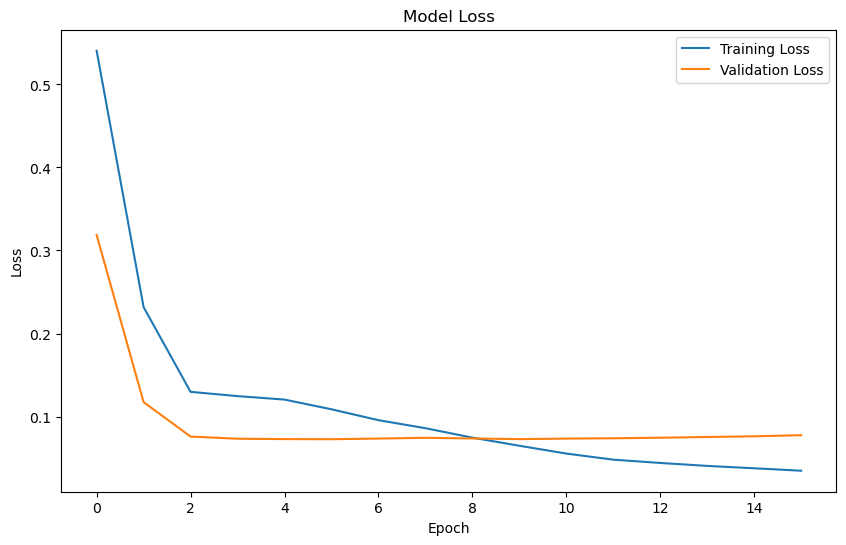

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


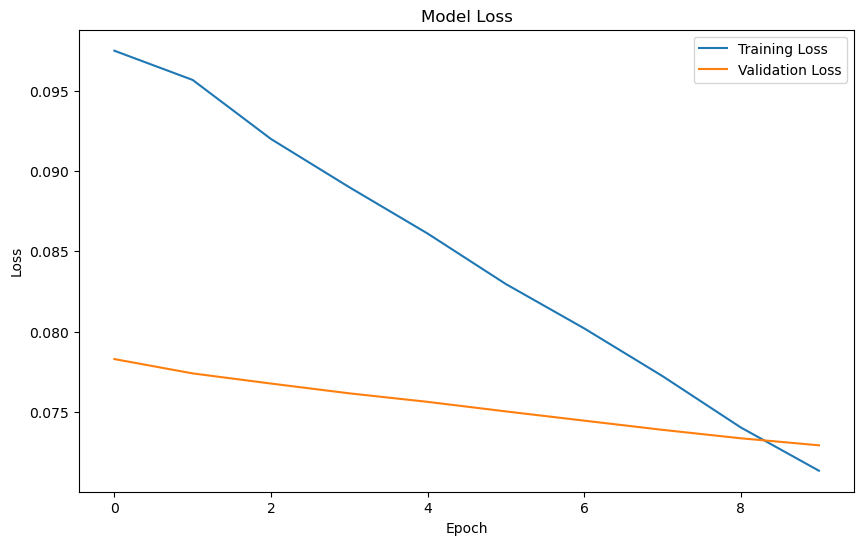

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


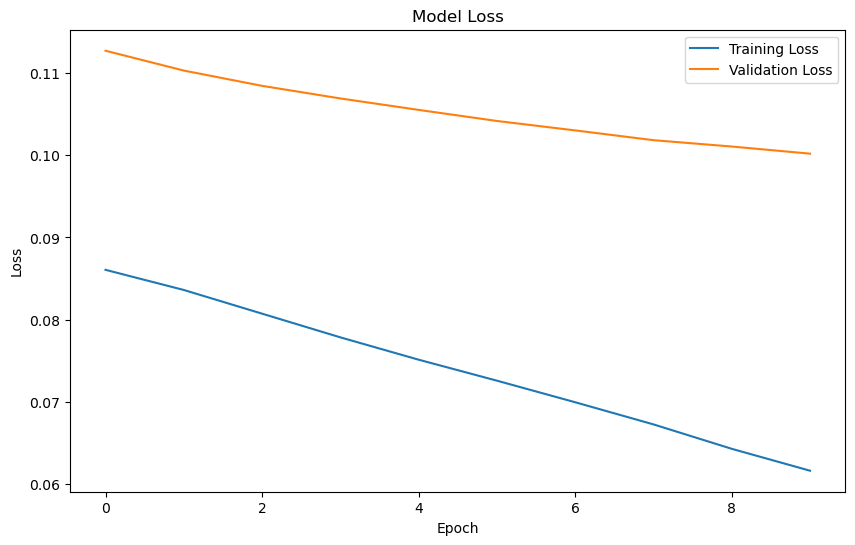

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


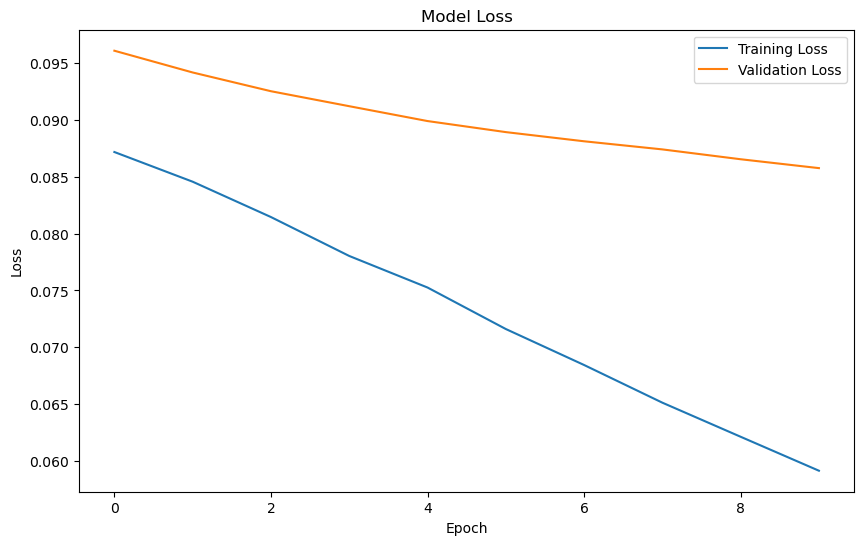

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


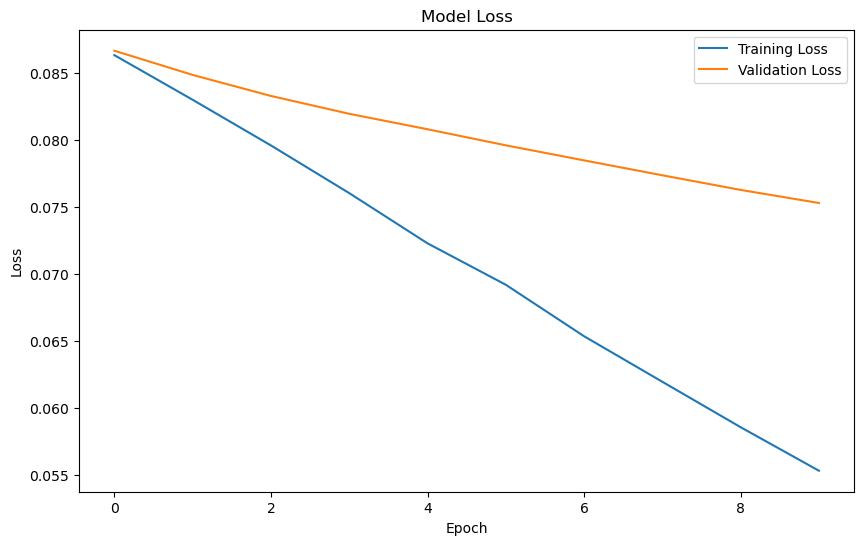

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [14]:
# Train and evaluate the neural network model
model, scores = neural_networks_model(X_train_t, y_train_t, X_test_t, y_test_t, neurons=64)

In [15]:
# Print the scores for each fold
print(f"Precision for each fold: {scores['precision']}")
print(f"Recall for each fold: {scores['recall']}")
print(f"F1 Score for each fold: {scores['f1']}")

# Calculate average scores across all folds
avg_precision = np.mean(scores['precision'])
avg_recall = np.mean(scores['recall'])
avg_f1 = np.mean(scores['f1'])

print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")

Precision for each fold: [0.0, 0.0, 0.0, 0.0, 0.0]
Recall for each fold: [0.0, 0.0, 0.0, 0.0, 0.0]
F1 Score for each fold: [0.0, 0.0, 0.0, 0.0, 0.0]
Average Precision: 0.0
Average Recall: 0.0
Average F1 Score: 0.0


## Current deep learning (tensorflow + keras) didn't work on my specific project.